# 1. Setup

## 1.1 Install Dependencies

In [1]:
!pip install opencv-python matplotlib

In [ ]:
!pip install tensorflow

## 1.2 Import Dependencies

In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.metrics import Precision, Recall

In [3]:
# Import tensorflow dependencies - Functional API
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

## 1.3 Set GPU Growth

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [120]:
# Make the directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [121]:
# http://vis-www.cs.umass.edu/lfw/

In [122]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
# !tar -xf lfw.tgz

In [123]:
# Move LFW Images to the following repository data/negative
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [6]:
# Import uuid library to generate unique image names
import uuid

In [7]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\aca898df-a4fe-11ed-aa94-e612441dc9c1.jpg'

In [8]:
# Establish a connection to the webcam
verf = './application_data/verification_images/'
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

# 2.x NEW - Data Augmentation

In [27]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [8]:
import os
import uuid

In [28]:
img_path = os.path.join(ANC_PATH, '1a58fcac-a479-11ed-b957-e8ebb8d73a51.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [29]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [9]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [10]:
dir_test = anchor.as_numpy_iterator()

In [11]:
print(dir_test.next())

b'data\\anchor\\8dad0b99-a48d-11ed-8c3e-e8ebb8d73a51.jpg'


## 3.2 Preprocessing - Scale and Resize

In [12]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [13]:
img = preprocess('data\\anchor\\2ca573e3-a479-11ed-8255-e8ebb8d73a51.jpg')

In [14]:
img.numpy().max() 

0.7134804

In [36]:
# dataset.map(preprocess)

## 3.3 Create Labelled Dataset

In [138]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [15]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [16]:
samples = data.as_numpy_iterator()

In [17]:
exampple = samples.next()

In [18]:
exampple

(b'data\\anchor\\8dad0b99-a48d-11ed-8c3e-e8ebb8d73a51.jpg',
 b'data\\positive\\34e2cb61-a4f9-11ed-bdd8-e8ebb8d73a51.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [19]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [20]:
res = preprocess_twin(*exampple)

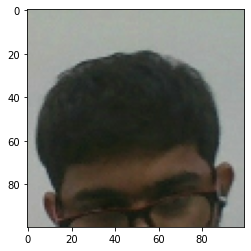

In [21]:
plt.imshow(res[1])

In [22]:
res[2]

1.0

In [23]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [24]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [25]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [26]:
inp = Input(shape=(100,100,3), name='input_image')

In [27]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [28]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [29]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [30]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [31]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [32]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [33]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [34]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [35]:
embedding = make_embedding()

In [36]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [37]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [38]:
l1 = L1Dist()

In [39]:
l1

## 4.3 Make Siamese Model

In [40]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [41]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [42]:
siamese_layer = L1Dist()

In [43]:
distances = siamese_layer(inp_embedding, val_embedding)

In [44]:
classifier = Dense(1, activation='sigmoid')(distances)

In [45]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [46]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [47]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [48]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [49]:
siamese_model = make_siamese_model()

In [50]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

## 5.1 Setup Loss and Optimizer

In [51]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [52]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [53]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [54]:
test_batch = train_data.as_numpy_iterator()

In [55]:
batch_1 = test_batch.next()

In [56]:
X = batch_1[:2]

In [57]:
y = batch_1[2]

In [58]:
y

array([1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1.],
      dtype=float32)

In [59]:
tf.losses.BinaryCrossentropy??

In [60]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [64]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [65]:
EPOCHS = 10

In [66]:
train(train_data, EPOCHS)


 Epoch 1/10
4/4 [==============================] - 84s 21s/step
0.39036787 0.96428573 0.96428573

 Epoch 2/10
4/4 [==============================] - 86s 21s/step
0.040561855 0.96428573 1.0

 Epoch 3/10
4/4 [==============================] - 86s 21s/step
0.038797487 0.9677419 1.0

 Epoch 4/10
4/4 [==============================] - 85s 20s/step
0.02457576 1.0 1.0

 Epoch 5/10
4/4 [==============================] - 82s 20s/step
0.030483223 1.0 1.0

 Epoch 6/10
4/4 [==============================] - 82s 20s/step
0.10010759 1.0 1.0

 Epoch 7/10
4/4 [==============================] - 82s 20s/step
0.016131582 1.0 1.0

 Epoch 8/10
4/4 [==============================] - 82s 20s/step
0.010235732 1.0 1.0

 Epoch 9/10
4/4 [==============================] - 82s 20s/step
0.06497081 1.0 1.0

 Epoch 10/10
4/4 [==============================] - 82s 20s/step
0.069501184 1.0 1.0


# 6. Evaluate Model

## 6.1 Import Metrics

In [67]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [68]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [69]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 2s 2s/step


array([[4.5400078e-04],
       [9.9768066e-01],
       [1.7855719e-02],
       [9.9999011e-01],
       [2.9639576e-03],
       [9.6954983e-01],
       [9.9904484e-01],
       [2.3532983e-04],
       [9.9708384e-01],
       [2.1792704e-03],
       [1.5288240e-02],
       [9.8961878e-01],
       [7.5721699e-01],
       [9.9840242e-01],
       [1.0814576e-03],
       [7.4720006e-03]], dtype=float32)

In [70]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]

In [71]:
y_true

array([0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [72]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [73]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [74]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 1s 1s/step
1.0 1.0


## 6.4 Viz Results

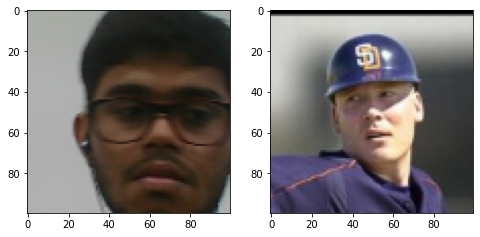

In [75]:
# Set plot size 
plt.figure(figsize=(8,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [76]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [77]:
L1Dist

__main__.L1Dist

In [78]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [79]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 1s/step


array([[3.9459034e-03],
       [9.8961878e-01],
       [9.3292128e-03],
       [4.6054916e-03],
       [2.2639409e-03],
       [9.5317107e-01],
       [1.7855719e-02],
       [9.2743731e-01],
       [7.8594714e-04],
       [9.9768066e-01]], dtype=float32)

In [80]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 8. Real Time Test

## 8.1 Verification Function

In [ ]:
# application_data\verification_images

In [233]:
os.listdir(os.path.join('application_data', 'verification_images'))

['8fe09035-a48d-11ed-b032-e8ebb8d73a51.jpg',
 '8fe17a94-a48d-11ed-8e17-e8ebb8d73a51.jpg',
 '8fe8591f-a48d-11ed-8328-e8ebb8d73a51.jpg',
 '8fe91c70-a48d-11ed-94f9-e8ebb8d73a51.jpg',
 '94a28d3a-a48d-11ed-9eb9-e8ebb8d73a51.jpg',
 '94a37735-a48d-11ed-a6c4-e8ebb8d73a51.jpg',
 '94a599fe-a48d-11ed-b545-e8ebb8d73a51.jpg',
 '94a65d5b-a48d-11ed-881a-e8ebb8d73a51.jpg',
 '94a76ee0-a48d-11ed-ab16-e8ebb8d73a51.jpg',
 '94a80b0d-a48d-11ed-8a8c-e8ebb8d73a51.jpg',
 '94d12daf-a48d-11ed-ad9a-e8ebb8d73a51.jpg',
 '94d217f4-a48d-11ed-aff8-e8ebb8d73a51.jpg',
 '94d30239-a48d-11ed-aac8-e8ebb8d73a51.jpg',
 '94d39e7a-a48d-11ed-9188-e8ebb8d73a51.jpg',
 '94d43ae7-a48d-11ed-8587-e8ebb8d73a51.jpg',
 '94d57351-a48d-11ed-a29a-e8ebb8d73a51.jpg',
 '94d60f8e-a48d-11ed-89af-e8ebb8d73a51.jpg',
 '94d6d330-a48d-11ed-84e8-e8ebb8d73a51.jpg',
 '94d7bd4a-a48d-11ed-b2b5-e8ebb8d73a51.jpg',
 '94fa1512-a48d-11ed-b1eb-e8ebb8d73a51.jpg',
 '94fb4d92-a48d-11ed-b7f8-e8ebb8d73a51.jpg',
 '94fbfdd4-a48d-11ed-a94d-e8ebb8d73a51.jpg',
 '94fd0f74

In [234]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [235]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\8fe09035-a48d-11ed-b032-e8ebb8d73a51.jpg
application_data\verification_images\8fe17a94-a48d-11ed-8e17-e8ebb8d73a51.jpg
application_data\verification_images\8fe8591f-a48d-11ed-8328-e8ebb8d73a51.jpg
application_data\verification_images\8fe91c70-a48d-11ed-94f9-e8ebb8d73a51.jpg
application_data\verification_images\94a28d3a-a48d-11ed-9eb9-e8ebb8d73a51.jpg
application_data\verification_images\94a37735-a48d-11ed-a6c4-e8ebb8d73a51.jpg
application_data\verification_images\94a599fe-a48d-11ed-b545-e8ebb8d73a51.jpg
application_data\verification_images\94a65d5b-a48d-11ed-881a-e8ebb8d73a51.jpg
application_data\verification_images\94a76ee0-a48d-11ed-ab16-e8ebb8d73a51.jpg
application_data\verification_images\94a80b0d-a48d-11ed-8a8c-e8ebb8d73a51.jpg
application_data\verification_images\94d12daf-a48d-11ed-ad9a-e8ebb8d73a51.jpg
application_data\verification_images\94d217f4-a48d-11ed-aff8-e8ebb8d73a51.jpg
application_data\verification_images\94d30239-a48d-11ed-aac8-e8e

In [236]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [241]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 263ms/step
True
1/1 [==============================] - 0s 346ms/step
True
1/1 [==============================] - 0s 332ms/step
False
1/1 [==============================] - 0s 261ms/step
False
1/1 [==============================] - 0s 334ms/step
True
1/1 [==============================] - 0s 335ms/step
True
1/1 [==============================] - 0s 255ms/step
False


In [242]:
np.sum(np.squeeze(results) > 0.9)

0

In [243]:
results

[array([[0.05363867]], dtype=float32),
 array([[0.0300306]], dtype=float32),
 array([[0.07447619]], dtype=float32),
 array([[0.18518698]], dtype=float32),
 array([[0.04685856]], dtype=float32),
 array([[0.08473037]], dtype=float32),
 array([[0.1722404]], dtype=float32),
 array([[0.21567103]], dtype=float32),
 array([[0.61339676]], dtype=float32),
 array([[0.65027547]], dtype=float32),
 array([[0.6625212]], dtype=float32),
 array([[0.6401033]], dtype=float32),
 array([[0.8263678]], dtype=float32),
 array([[0.11735232]], dtype=float32),
 array([[0.5586323]], dtype=float32),
 array([[0.2668081]], dtype=float32)]